In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import random

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.data import Dataset
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from sklearn.model_selection import train_test_split
import pydensecrf.densecrf as dcrf
from keras_unet_collection import models, losses

2024-05-08 13:14:24.729540: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vsc-hard-mounts/leuven-data/360/vsc36057/miniconda3/envs/myenv3.7/lib/python3.7/site-packages/cv2/../../lib64:
2024-05-08 13:14:24.729561: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:


# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

IMAGE_DIR = '/data/leuven/360/vsc36057/images-masks-full-black-png/images'
MASK_DIR = '/data/leuven/360/vsc36057/images-masks-full-black-png/masks'
BATCH_SIZE=4
EPOCHS=5
LR = 1e-4
HEIGHT = 512
WIDTH = 512

sample_mask = cv2.imread('/data/leuven/360/vsc36057/images-masks-full-black-png/images/exp1_F0001-00017.png',cv2.IMREAD_GRAYSCALE)
num_classes = 2
height = sample_mask.shape[0]
width = sample_mask.shape[1]
print('the number of total classes: ', num_classes)
print('sample image height {}, width {}'.format(height, width))

image_paths = glob(os.path.join(IMAGE_DIR, '*.png'))
image_paths.sort()
mask_paths = glob(os.path.join(MASK_DIR, '*.png'))
mask_paths.sort()
print('total number of images: ', len(image_paths))

train_x, test_x, train_y, test_y = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
print('total number of images in training set: ', len(train_x))
print('total number of images in testing set: ', len(test_x))

the number of total classes:  2
sample image height 1040, width 1392
total number of images:  480
total number of images in training set:  384
total number of images in testing set:  96


In [3]:
def read_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = image / 255.0
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [HEIGHT, WIDTH])
    mask = tf.cast(tf.squeeze(mask), dtype=tf.int32)
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    return image, mask

def augment_image_batch1(image, mask):
    new_seed = np.random.randint(100)
    print(image.shape)
    print(mask.shape)
    image = tf.image.resize(image, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    mask = tf.image.resize(mask, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    image = tf.image.random_crop(image, (HEIGHT, WIDTH, 3), seed=new_seed)
    mask = tf.image.random_crop(mask, (HEIGHT, WIDTH, num_classes), seed=new_seed)
    image = tf.image.random_flip_left_right(image, seed=new_seed)
    mask = tf.image.random_flip_left_right(mask, seed=new_seed)
    mask = tf.cast(mask, dtype=tf.int32)
    return image,mask

def augment_image_batch2(image, mask):
    new_seed = np.random.randint(100)
    image = tf.image.resize(image, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    mask = tf.image.resize(mask, [int(1.2 * HEIGHT), int(1.2 * WIDTH)])
    image = tf.image.random_crop(image, (HEIGHT, WIDTH, 3), seed=new_seed)
    mask = tf.image.random_crop(mask, (HEIGHT, WIDTH, num_classes), seed=new_seed)
    image = tf.image.random_flip_up_down(image, seed=new_seed)
    mask = tf.image.random_flip_up_down(mask, seed=new_seed)
    mask = tf.cast(mask, dtype=tf.int32)
    return image,mask

In [4]:
train_ds = Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.map(read_image)
train_ds1 = train_ds.map(augment_image_batch1)
train_ds2 = train_ds.map(augment_image_batch2)
train_ds = train_ds.concatenate(train_ds1.concatenate(train_ds2))
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = Dataset.from_tensor_slices((test_x, test_y))
test_ds = test_ds.map(read_image)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

2024-05-08 13:14:39.233359: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-08 13:14:39.234099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-08 13:14:39.258305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: NVIDIA A100 80GB PCIe MIG 1g.10gb computeCapability: 8.0
coreClock: 1.41GHz coreCount: 14 deviceMemorySize: 9.50GiB deviceMemoryBandwidth: 225.30GiB/s
2024-05-08 13:14:39.258393: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /vsc-hard-mounts/leuven-data/360/vsc36057/miniconda3/envs/myenv3.7/lib/python3.7/site-packages/cv2/../../lib64:
2024-05-08 13:14:39.258435: W tensorflow/stream_executor/platform

(512, 512, 3)
(512, 512, 2)


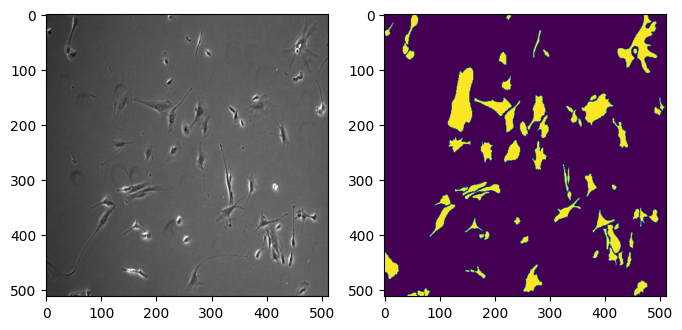

In [5]:
from IPython.display import clear_output

fg, ax = plt.subplots(1,2, figsize=(8,16))
for image, mask in test_ds.take(1):
    ax[0].imshow(image[1,...])
    ax[1].imshow(tf.argmax(mask[1,...],axis=-1))

clear_output()

In [6]:
tf.keras.backend.clear_session()
model = models.swin_unet_2d((512, 512, 3), filter_num_begin=32,
                               n_labels=num_classes, depth=4, stack_num_down=2, stack_num_up=2,
                               patch_size=(4, 4), num_heads=[4, 8, 8, 8],
                               window_size=[4, 2, 2, 2], num_mlp=156, 
                               output_activation='Softmax', shift_window=True,
                               name='swin_unet')
print(model.summary())

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 48)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 32)    525856      patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 32)    14976       patch_embedding[0][0]            
____________________________________________________________________________________

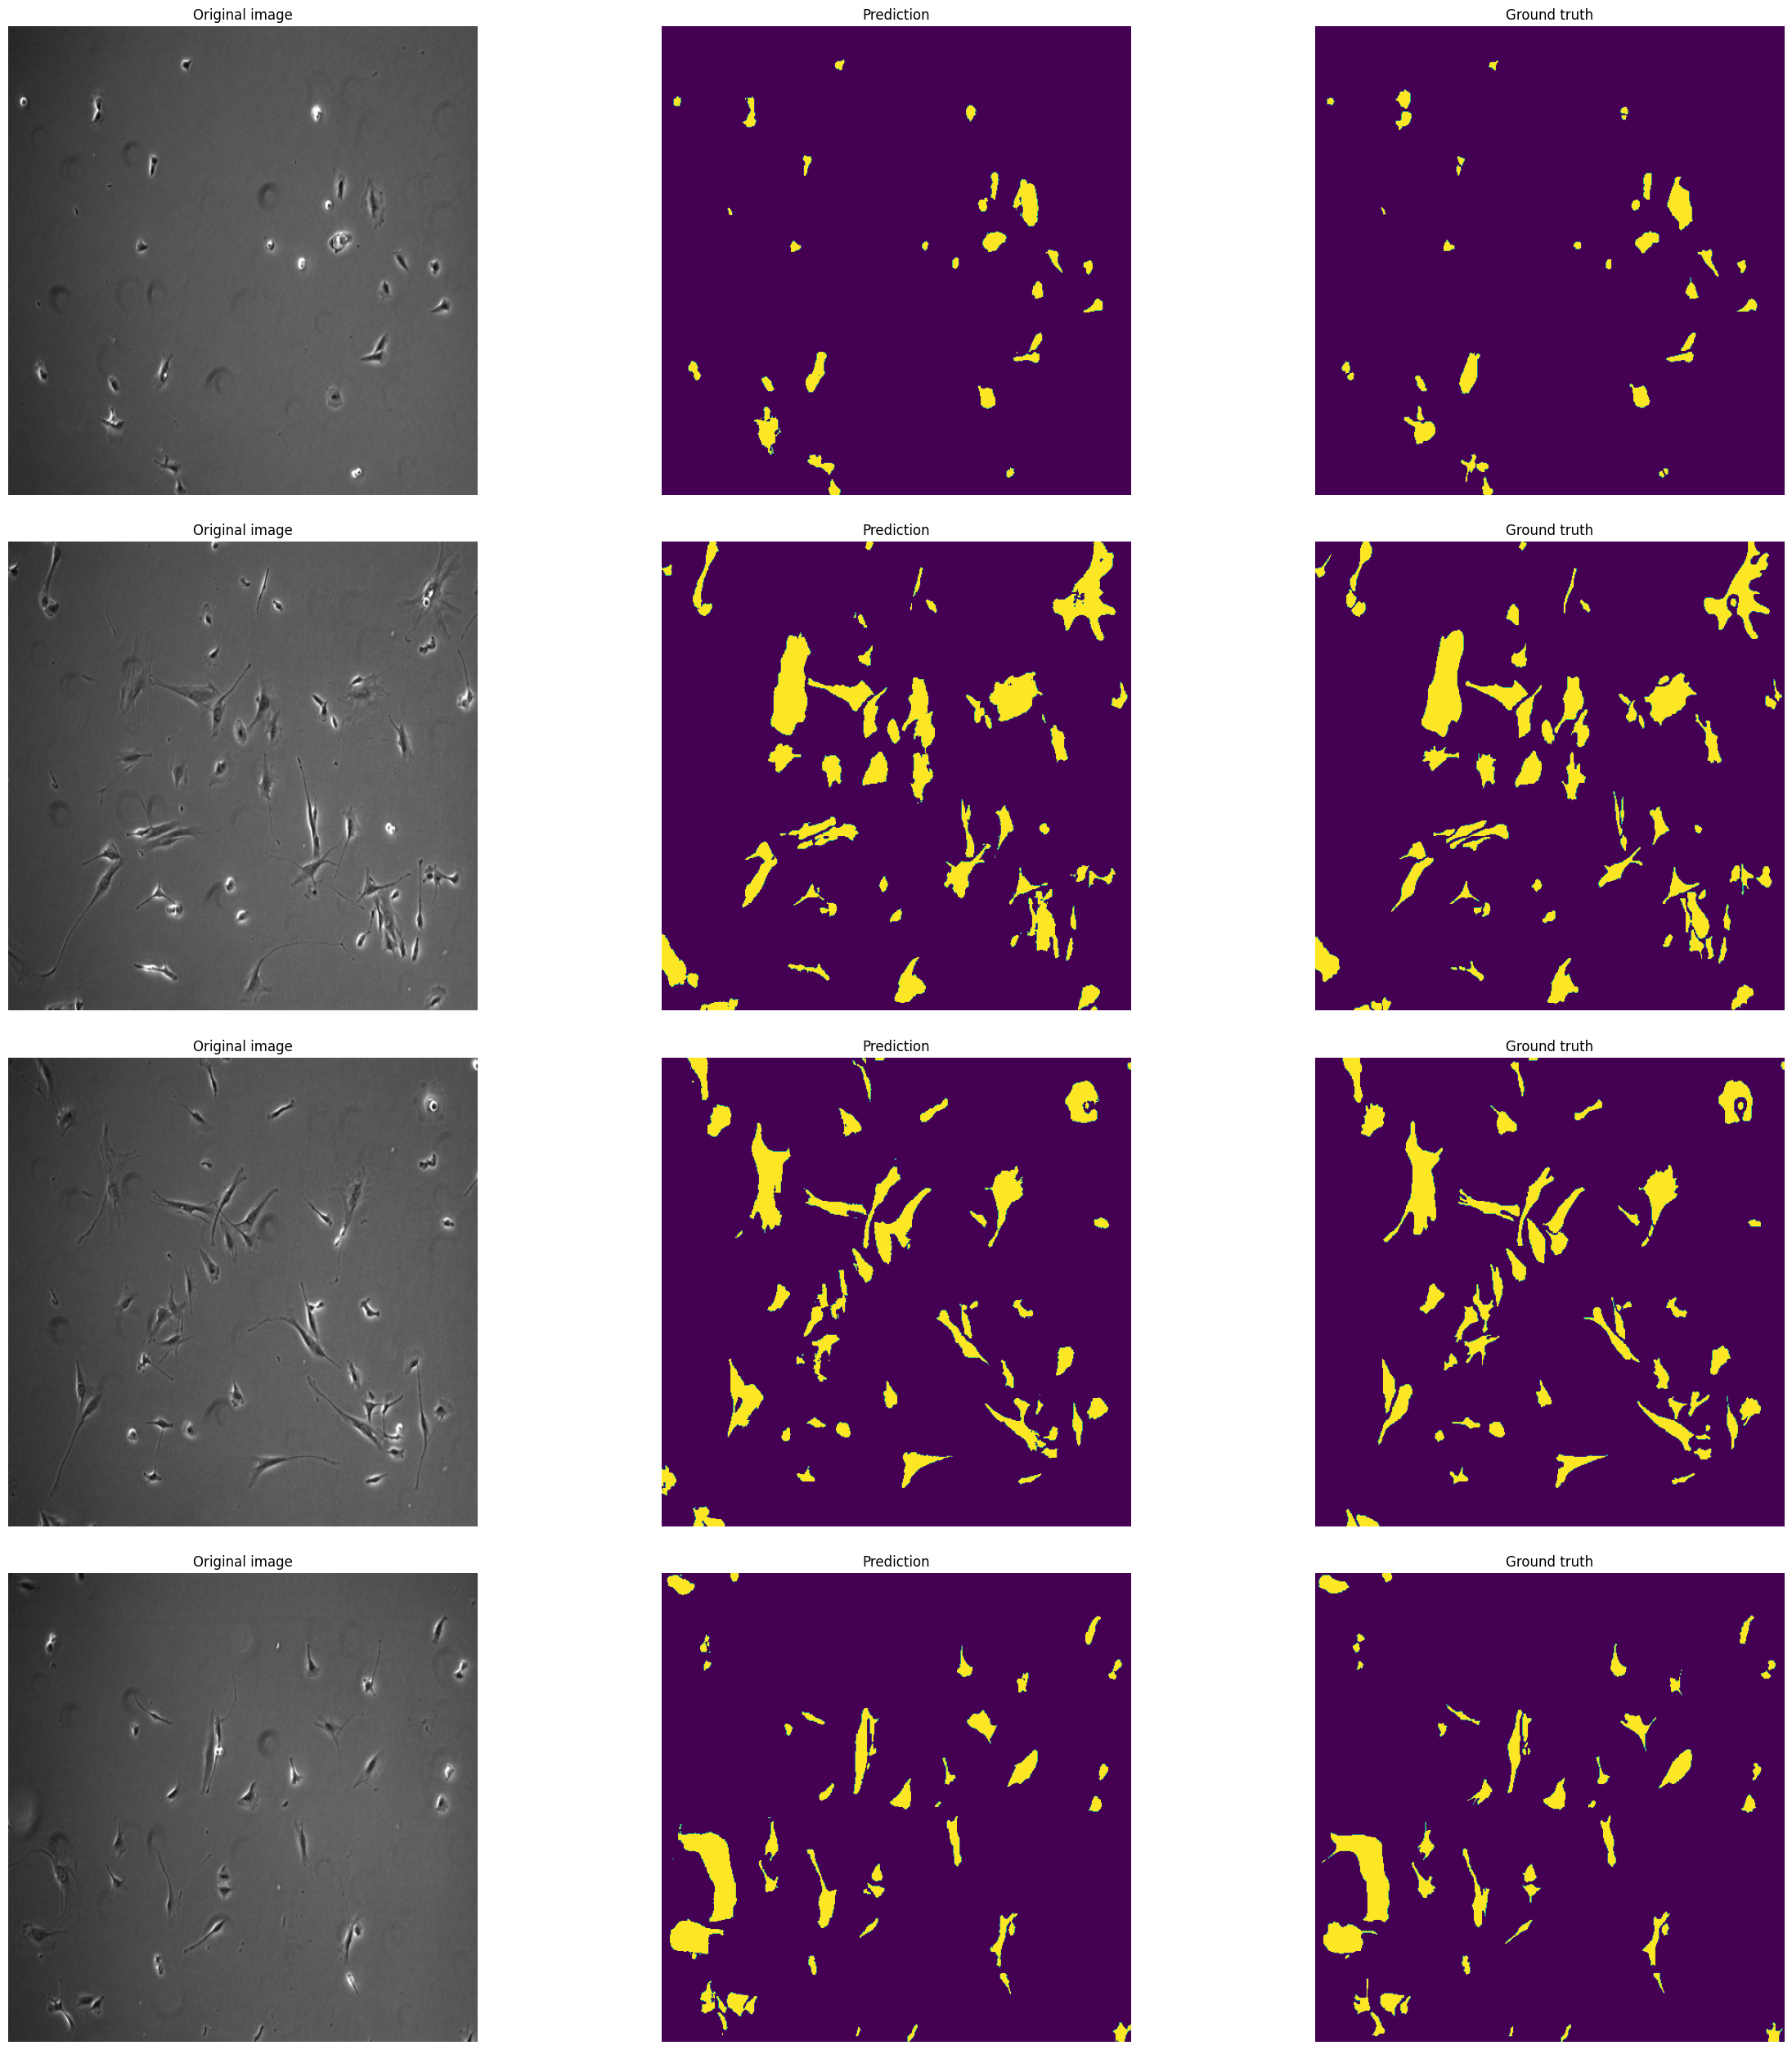

In [12]:
import matplotlib.pyplot as plt

# I assume you have BATCH_SIZE, images, predictions, and labels defined somewhere above this code.

# Increase the figure size for larger images. You can adjust these numbers as needed.
fig, ax = plt.subplots(BATCH_SIZE, 3, figsize=(30, 8 * BATCH_SIZE))

# Reduce the width and height padding between subplots.
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for j in range(BATCH_SIZE):
    ax[j, 0].imshow(images[j, ...].numpy())
    ax[j, 1].imshow(predictions[j, ...].astype('uint8'))
    ax[j, 2].imshow(labels[j, ...])
    ax[j, 0].set_title('Original image')
    ax[j, 1].set_title('Prediction')
    ax[j, 2].set_title('Ground truth')

    # Remove the axis to make the images larger and remove unnecessary visual clutter
    ax[j, 0].axis('off')
    ax[j, 1].axis('off')
    ax[j, 2].axis('off')

plt.show()


In [15]:
import matplotlib.pyplot as plt
import os

# Assuming BATCH_SIZE, images, predictions, and labels are defined in your setup

# Directory to save the images
save_dir = '/data/leuven/360/vsc36057/swin-unet/inference_images'
os.makedirs(save_dir, exist_ok=True)

for j in range(BATCH_SIZE):
    # Save each image in a separate file
    fig, ax = plt.subplots()

    # Display original image
    ax.imshow(images[j, ...].numpy(), cmap='gray', interpolation='lanczos')
    ax.axis('off')
    fig.savefig(os.path.join(save_dir, f'original_image_{j}.png'), dpi=300, bbox_inches='tight', pad_inches=0, format='png')
    plt.close(fig)  # Close the figure to free up memory
    
    # Save predicted mask
    fig, ax = plt.subplots()
    ax.imshow(predictions[j, ...].astype('uint8'), cmap='gray', interpolation='lanczos')
    ax.axis('off')
    fig.savefig(os.path.join(save_dir, f'predicted_mask_{j}.png'), dpi=300, bbox_inches='tight', pad_inches=0, format='png')
    plt.close(fig)  # Close the figure to free up memory

    # Save ground truth image
    fig, ax = plt.subplots()
    ax.imshow(labels[j, ...], cmap='gray', interpolation='lanczos')
    ax.axis('off')
    fig.savefig(os.path.join(save_dir, f'ground_truth_{j}.png'), dpi=300, bbox_inches='tight', pad_inches=0, format='png')
    plt.close(fig)  # Close the figure to free up memory


Image 1: True mask has 30 components, Prediction has 42 components
Image 2: True mask has 32 components, Prediction has 30 components
Image 3: True mask has 41 components, Prediction has 42 components
Image 4: True mask has 29 components, Prediction has 28 components


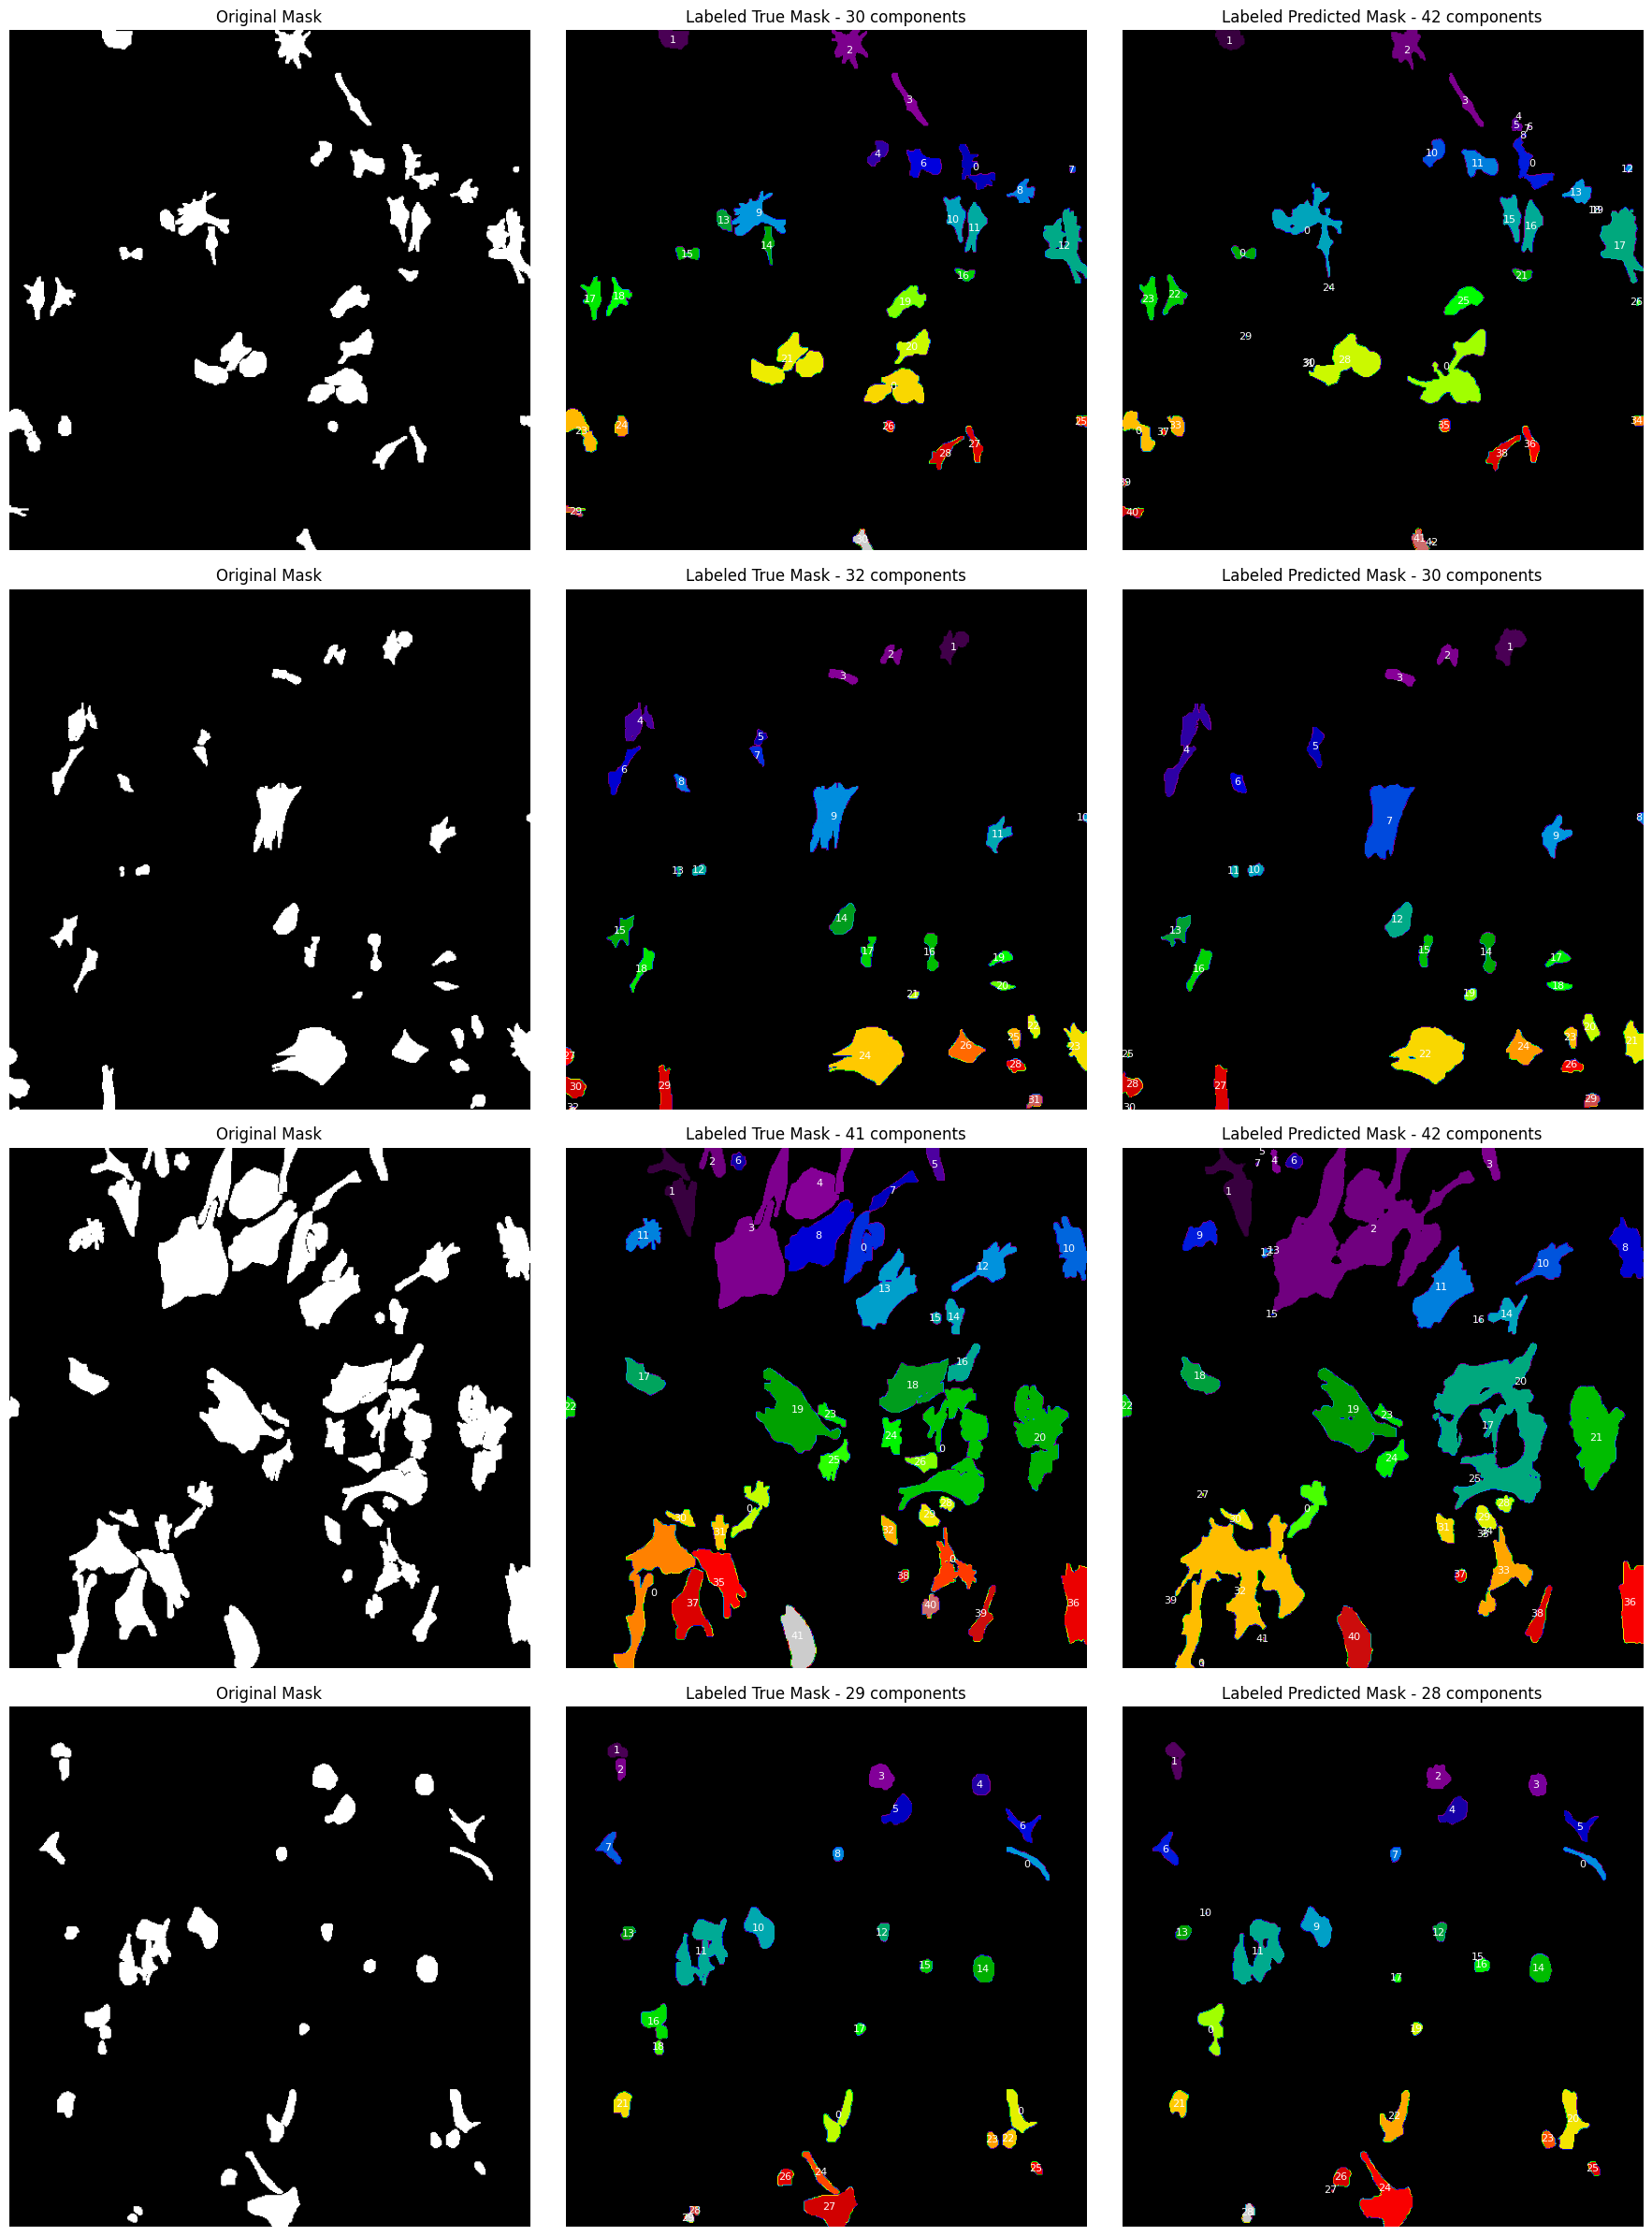

In [4]:
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import torch



# Number of images to display
num_images = min(4, all_predictions_tensor.size(0))

# Create figure with subplots
fig, axes = plt.subplots(num_images, 3, figsize=(18, 6 * num_images))

def plot_labeled_mask_with_numbers(ax, labeled_mask, title, num_features):
    ax.imshow(labeled_mask, cmap='nipy_spectral')
    ax.set_title(f"{title} - {num_features} components")
    ax.axis('off')
    for region in ndi.find_objects(labeled_mask):
        if region is not None:
            slice_x, slice_y = region
            x_center = (slice_x.start + slice_x.stop - 1) // 2
            y_center = (slice_y.start + slice_y.stop - 1) // 2
            label = labeled_mask[x_center, y_center]
            ax.text(y_center, x_center, str(label), color='white', ha='center', va='center', fontsize=8)

for i in range(num_images):
    # Assume all_labels_tensor and all_predictions_tensor are already 2D masks
    # No need to permute as these are not 3D tensors
    true_mask = all_labels_tensor[i].numpy()
    pred_mask = all_predictions_tensor[i].numpy()

    # Label the connected components
    labeled_true_mask, num_features_true = ndi.label(true_mask)
    labeled_pred_mask, num_features_pred = ndi.label(pred_mask)

    # Print number of connected components
    print(f"Image {i+1}: True mask has {num_features_true} components, Prediction has {num_features_pred} components")

    # Display the original mask
    axes[i, 0].imshow(true_mask, cmap='gray')
    axes[i, 0].set_title('Original Mask')
    axes[i, 0].axis('off')

    # Display the labeled true mask with component numbers
    plot_labeled_mask_with_numbers(axes[i, 1], labeled_true_mask, 'Labeled True Mask', num_features_true)

    # Display the labeled predicted mask with component numbers
    plot_labeled_mask_with_numbers(axes[i, 2], labeled_pred_mask, 'Labeled Predicted Mask', num_features_pred)

plt.tight_layout()
plt.show()


In [1]:
import tensorflow as tf
import numpy as np

# Assuming 'test_ds' is your testing dataset, already batched appropriately
all_predictions = []
all_labels = []

# Loop through the entire dataset
for images, masks in test_ds:
    # Get model predictions for each batch of images
    pred = model.predict(images)

    # Convert predictions and true labels to the argmax over the last dimension
    predictions = np.argmax(pred, axis=-1)
    labels = np.argmax(masks.numpy(), axis=-1)  # Convert masks to numpy arrays if they aren't already

    # Store predictions and labels in lists
    all_predictions.append(predictions)
    all_labels.append(labels)

# Concatenate all predictions and labels along a new dimension
# This assumes each batch's predictions and labels are shaped correctly to concatenate into the desired shape
# For example, if batches produce outputs of shape [N, 512, 512], where N is the batch size,
# and total N across all batches is 96, then the following will work:
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Now all_predictions and all_labels should each be of shape (96, 512, 512)
print(all_labels.shape)
print(all_predictions.shape)

# Ensure the concatenated results match your expected shape:
assert all_predictions.shape == (96, 512, 512), "Predictions shape mismatch"
assert all_labels.shape == (96, 512, 512), "Labels shape mismatch"


2024-05-04 16:16:15.551490: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-04 16:16:15.551511: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


NameError: name 'test_ds' is not defined

In [9]:
import tensorflow as tf
import numpy as np

# Assuming 'test_ds' is your testing dataset, already batched appropriately
all_probabilities = []
all_labels = []

# Loop through the entire dataset
for images, masks in test_ds:
    # Get model predictions for each batch of images
    # These are the softmax probabilities across the classes for each pixel (if doing pixel-wise classification)
    probabilities = model.predict(images)

    # Convert masks to numpy arrays if they aren't already and apply argmax to get labels if needed
    labels = np.argmax(masks.numpy(), axis=-1)  # Convert masks to numpy arrays if they aren't already

    # Store probabilities and labels in lists
    all_probabilities.append(probabilities)
    all_labels.append(labels)

# Concatenate all probabilities and labels along a new dimension
# This assumes each batch's probabilities and labels are shaped correctly to concatenate into the desired shape
# For example, if batches produce outputs of shape [N, 512, 512, num_classes], where N is the batch size,
# and total N across all batches is 96, then the following will work:
all_probabilities = np.concatenate(all_probabilities, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Now all_probabilities should be of shape (96, 512, 512, num_classes) and all_labels of shape (96, 512, 512)
print(all_labels.shape)
print(all_probabilities.shape)

# Ensure the concatenated results match your expected shape:
assert all_probabilities.shape[:3] == (96, 512, 512) and all_probabilities.shape[3] > 1, "Probabilities shape mismatch"
assert all_labels.shape == (96, 512, 512), "Labels shape mismatch"


(96, 512, 512)
(96, 512, 512, 2)


In [10]:
print(all_probabilities)

[[[[9.99997377e-01 2.64073697e-06]
   [9.99999404e-01 5.68845792e-07]
   [9.99999642e-01 3.00088516e-07]
   ...
   [9.99997020e-01 3.03370530e-06]
   [9.99994874e-01 5.08467747e-06]
   [9.99987125e-01 1.29031632e-05]]

  [[9.99999166e-01 8.79629908e-07]
   [9.99999881e-01 1.38780678e-07]
   [1.00000000e+00 3.85538108e-08]
   ...
   [9.99999762e-01 2.37559007e-07]
   [9.99999642e-01 3.53743530e-07]
   [9.99998927e-01 1.10242252e-06]]

  [[9.99999523e-01 5.32665069e-07]
   [9.99999881e-01 7.58780487e-08]
   [1.00000000e+00 1.52539350e-08]
   ...
   [1.00000000e+00 4.14811829e-08]
   [1.00000000e+00 5.80762780e-08]
   [9.99999762e-01 2.54938470e-07]]

  ...

  [[9.99993205e-01 6.77244725e-06]
   [9.99998450e-01 1.58736793e-06]
   [9.99999166e-01 7.78445099e-07]
   ...
   [9.99999881e-01 9.13471041e-08]
   [9.99999881e-01 1.50109926e-07]
   [9.99999523e-01 5.24649465e-07]]

  [[9.99936342e-01 6.36577242e-05]
   [9.99978423e-01 2.15377313e-05]
   [9.99988556e-01 1.14149716e-05]
   ...
   [9

In [10]:
np.save('/data/leuven/360/vsc36057/swin-unet/numpy softmax output/all_probabilities.npy', all_probabilities)
np.save('/data/leuven/360/vsc36057/swin-unet/numpy softmax output/all_labels.npy', all_labels)

In [6]:
import torch
import numpy as np

# Load the numpy arrays from the disk
all_probabilities = np.load('/data/leuven/360/vsc36057/transunet/transresunet/binaries/binary_predictions-large.npy')
all_labels = np.load('/data/leuven/360/vsc36057/transunet/transresunet/binaries/binary_targets-large.npy')

# Convert numpy arrays to PyTorch tensors
all_predictions_tensor = torch.from_numpy(all_probabilities)
all_labels_tensor = torch.from_numpy(all_labels)

# Check if labels tensor has a redundant last dimension and squeeze if necessary
if all_labels_tensor.dim() > 3 and all_labels_tensor.size(-1) == 1:
    all_labels_tensor = all_labels_tensor.squeeze(-1)

print(all_predictions_tensor.shape)
print(all_labels_tensor.shape)  # Expected output for labels: torch.Size([96, 512, 512])


torch.Size([96, 512, 512])
torch.Size([96, 512, 512])


In [1]:
import numpy as np

# Load the targets from the file
file_path = "/data/leuven/360/vsc36057/transunet/transresunet/targets.npy"
targets = np.load(file_path)

# Flatten the targets array
flattened_targets = targets.flatten()

# Define the path to save the flattened array
output_path = "/data/leuven/360/vsc36057/transunet/transresunet/flattened_targets.npy"

# Save the flattened array to the output path
np.save(output_path, flattened_targets)


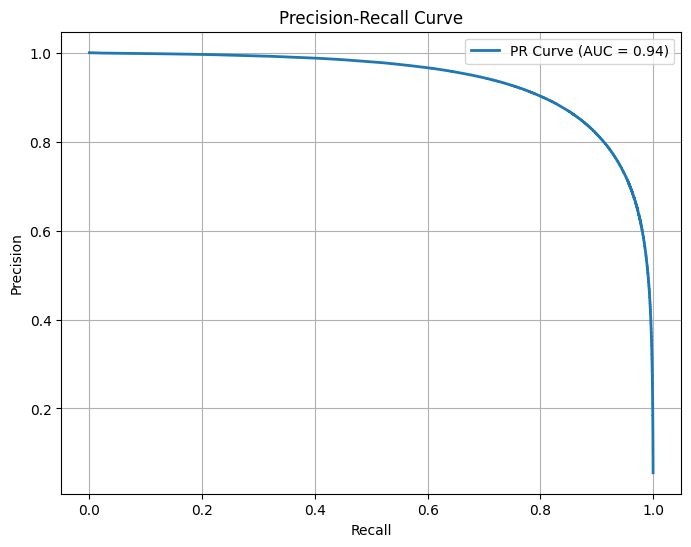

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Load the numpy arrays from the disk
all_probabilities = np.load('/data/leuven/360/vsc36057/swin-unet/numpy softmax output/all_probabilities.npy')
all_labels = np.load('/data/leuven/360/vsc36057/swin-unet/numpy softmax output/all_labels.npy')

# Convert numpy arrays to PyTorch tensors
all_predictions_tensor = torch.from_numpy(all_probabilities)
all_labels_tensor = torch.from_numpy(all_labels)

# Extract probabilities for Class 1
class_1_probabilities = all_predictions_tensor[..., 1]  # Get the probabilities for class 1

# Flatten the tensors for PR curve calculation
probabilities_flat = class_1_probabilities.flatten()
labels_flat = all_labels_tensor.flatten()

# Generate precision-recall values
precision, recall, thresholds = precision_recall_curve(labels_flat, probabilities_flat)
pr_auc = auc(recall, precision)

# Plotting the PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})', lw=2)  # lw is line width
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [12]:
print(all_predictions_tensor)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [3]:
print(all_predictions_tensor.shape)
print(all_labels_tensor.shape)

torch.Size([96, 512, 512])
torch.Size([96, 512, 512])


In [7]:
# Convert the tensors to numpy arrays and flatten them
all_predictions_np = all_predictions_tensor.cpu().numpy().flatten()
all_labels_np = all_labels_tensor.cpu().numpy().flatten()

# Check the shapes
print("Shape of all_predictions_np:", all_predictions_np.shape)
print("Shape of all_labels_np:", all_labels_np.shape)

Shape of all_predictions_np: (25165824,)
Shape of all_labels_np: (25165824,)


In [9]:
import torch
import torchmetrics
import numpy as np
import scipy.ndimage as ndi
import pandas as pd

          1         2         3        4         5         6         7   \
1   0.821569  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
2   0.000000  0.841289  0.000000  0.00000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.804245  0.00000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.00000  0.744711  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.87538  0.000000  0.000000  0.000000   
6   0.000000  0.000000  0.000000  0.00000  0.000000  0.919866  0.000000   
7   0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.567568   
8   0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
9   0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
10  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
11  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
12  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
13  0.000000  0.000000  0

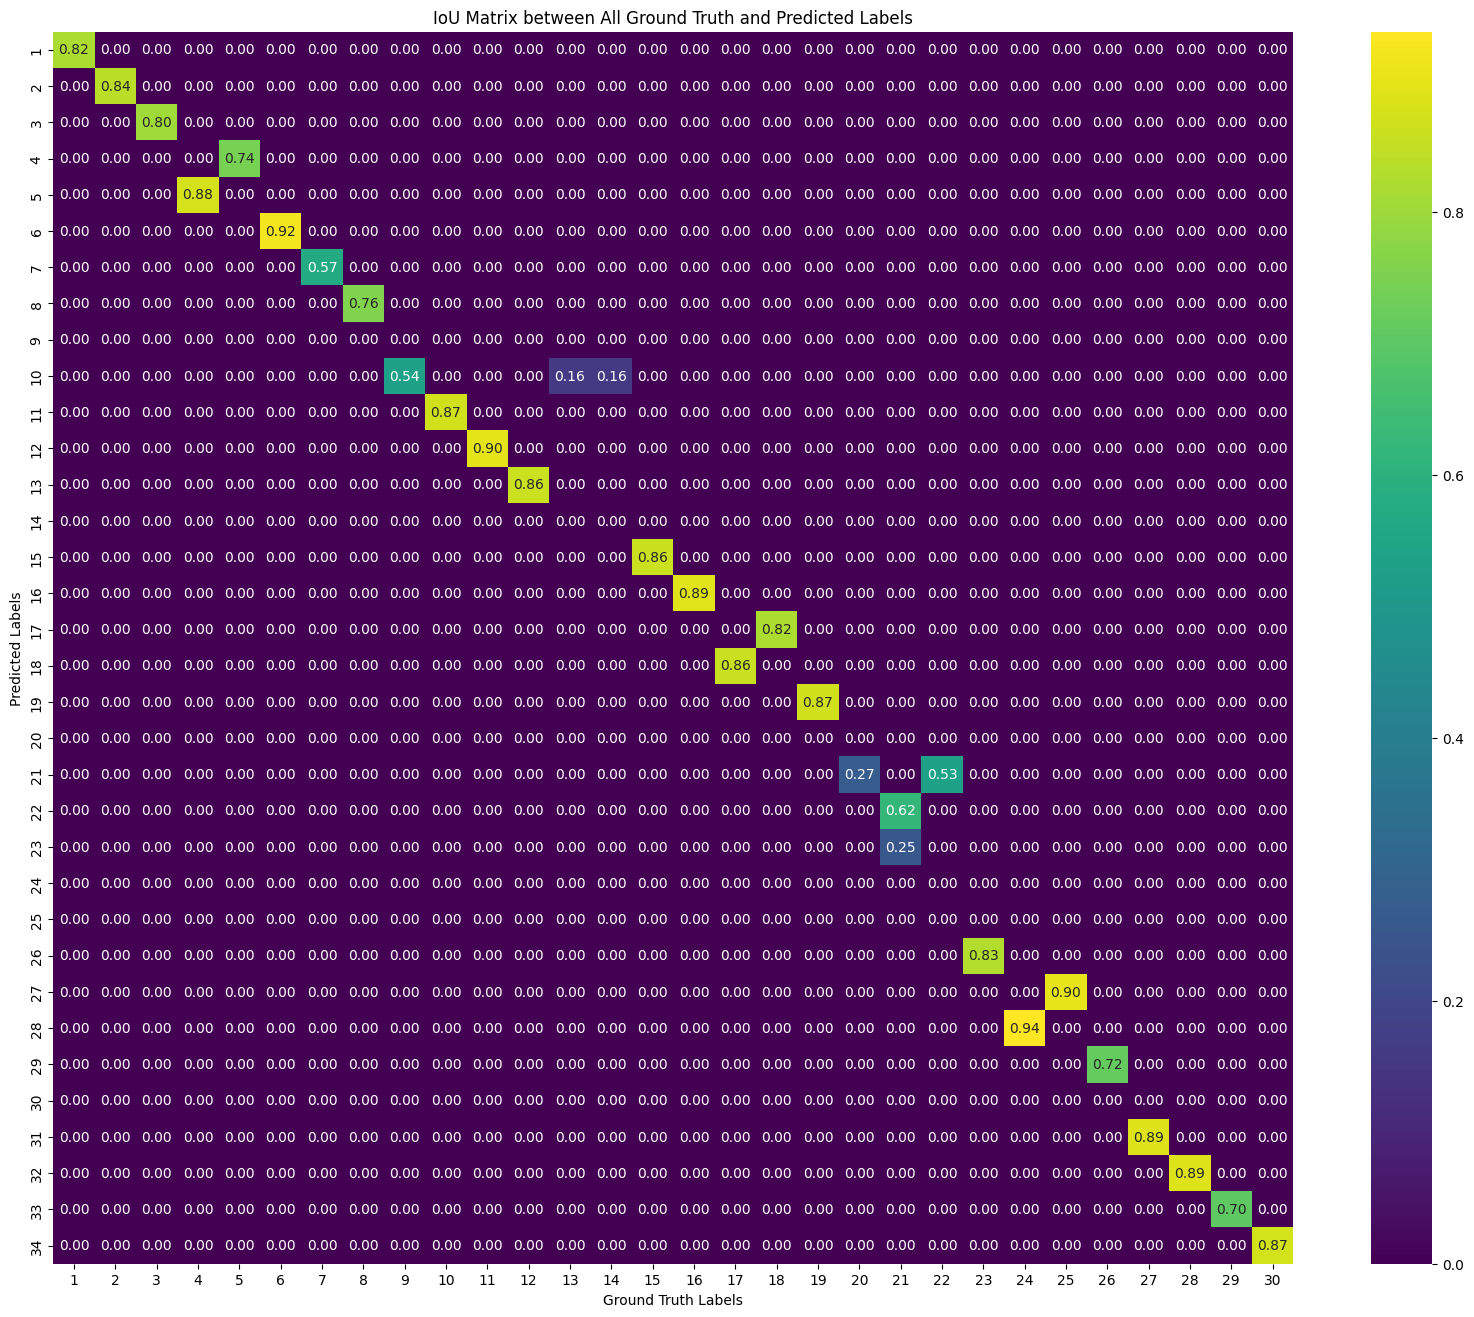

   IoU Threshold  True Positives  False Positives  False Negatives  \
0            0.5              27                3                7   
1            0.6              24                6               10   
2            0.7              23                7               11   
3            0.8              19               11               15   
4            0.9               3               27               31   

   Average Precision  
0           0.729730  
1           0.600000  
2           0.560976  
3           0.422222  
4           0.049180  
          1         2         3         4         5         6         7   \
1   0.838602  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.865455  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.004348  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.793358  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.798193  0.000000  0.00000

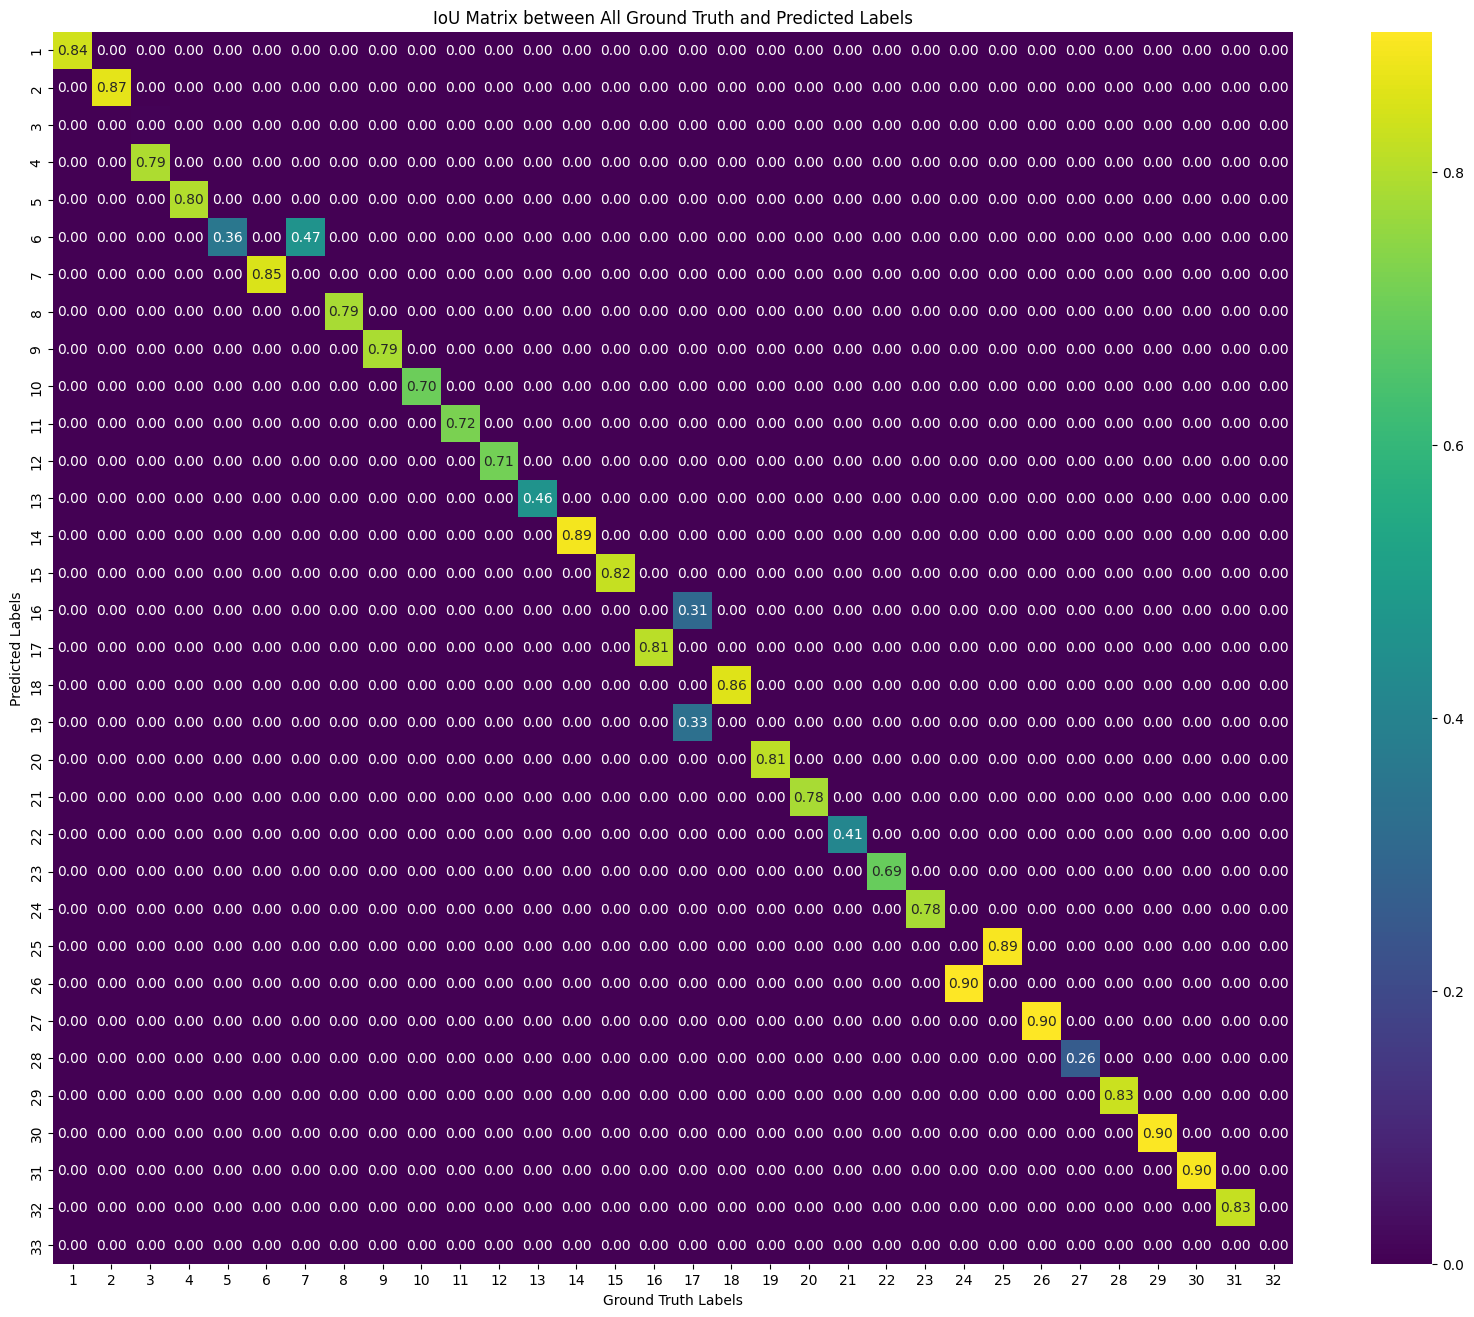

   IoU Threshold  True Positives  False Positives  False Negatives  \
0            0.5              25                7                8   
1            0.6              25                7                8   
2            0.7              23                9               10   
3            0.8              15               17               18   
4            0.9               2               30               31   

   Average Precision  
0           0.625000  
1           0.625000  
2           0.547619  
3           0.300000  
4           0.031746  
          1         2         3         4         5         6         7   \
1   0.866667  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.493172  0.194545  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.843342  0.000000  0.000000   
4   0.000000  0.006263  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.235908  0.000000  0.000000  0.000000  0.00000

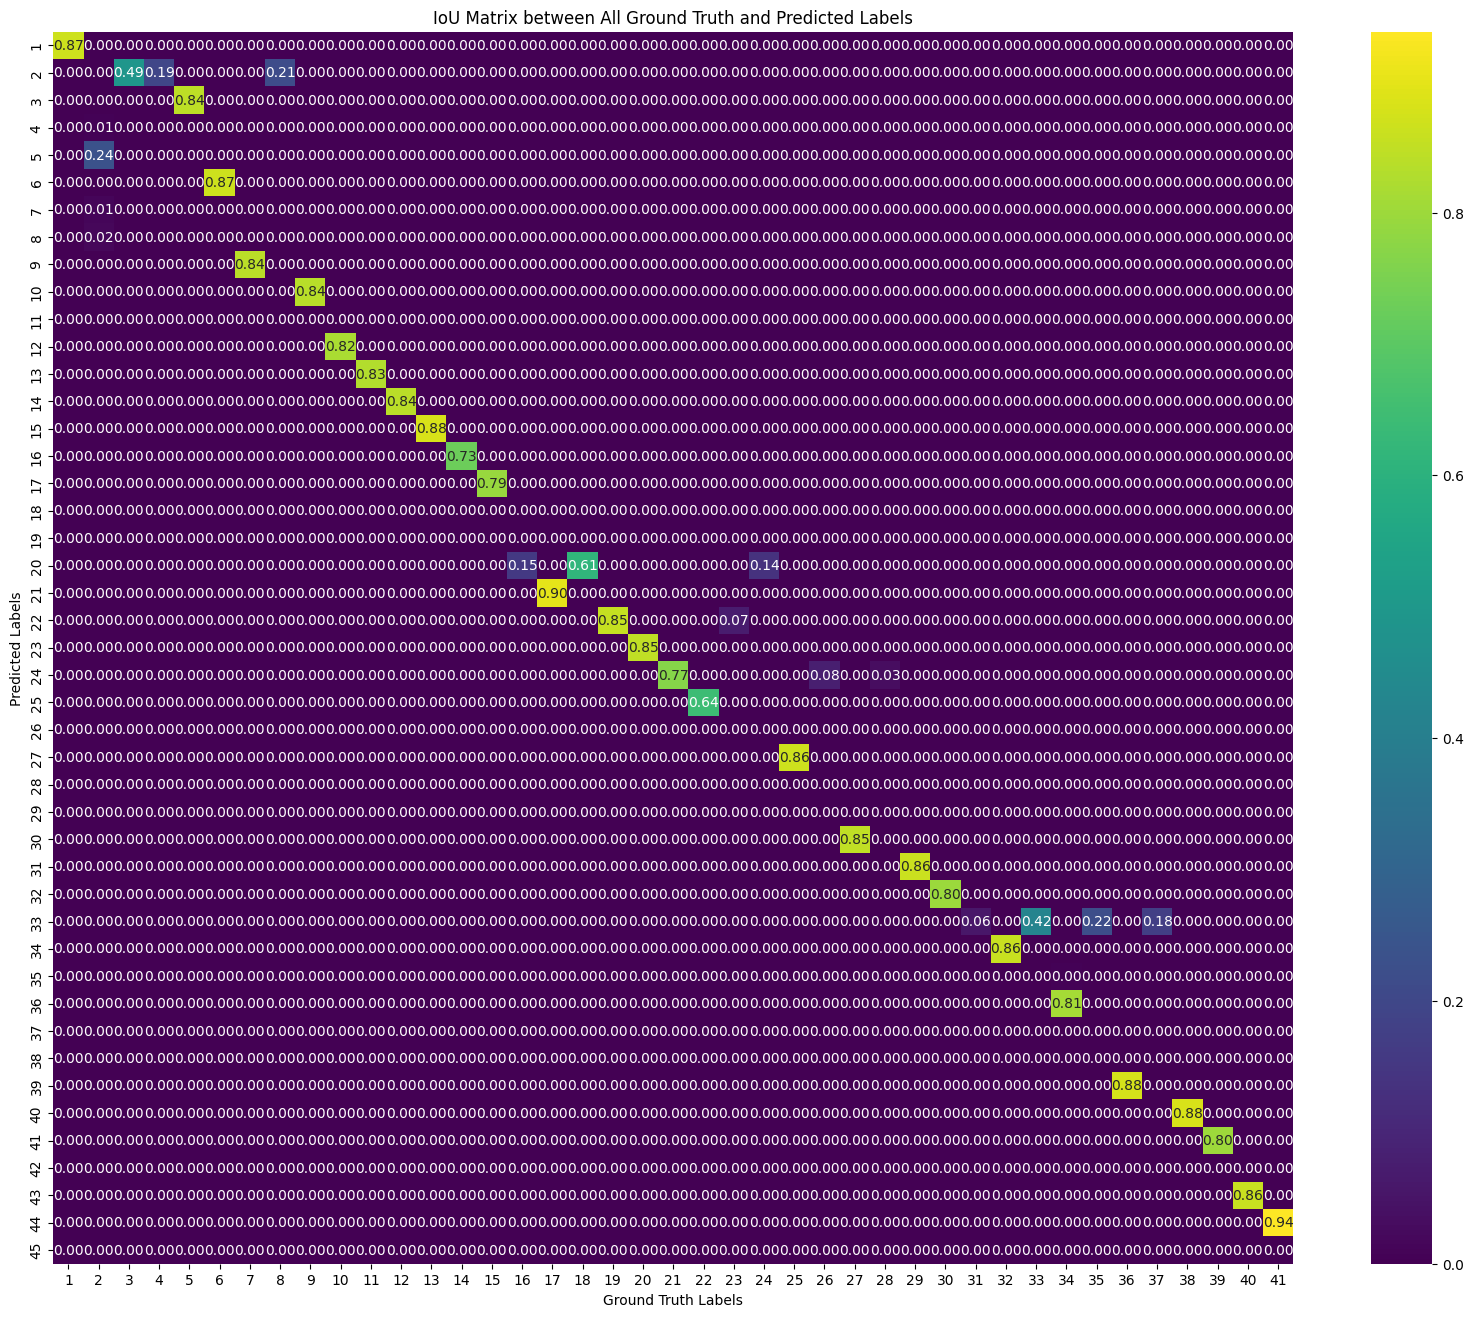

   IoU Threshold  True Positives  False Positives  False Negatives  \
0            0.5              28               13               17   
1            0.6              28               13               17   
2            0.7              26               15               19   
3            0.8              21               20               24   
4            0.9               1               40               44   

   Average Precision  
0           0.482759  
1           0.482759  
2           0.433333  
3           0.323077  
4           0.011765  
          1         2        3         4         5         6         7   \
1   0.851562  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.754011  0.00000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.88668  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.00000  0.935294  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.00000  0.000000  0.868762  0.000000  0.0

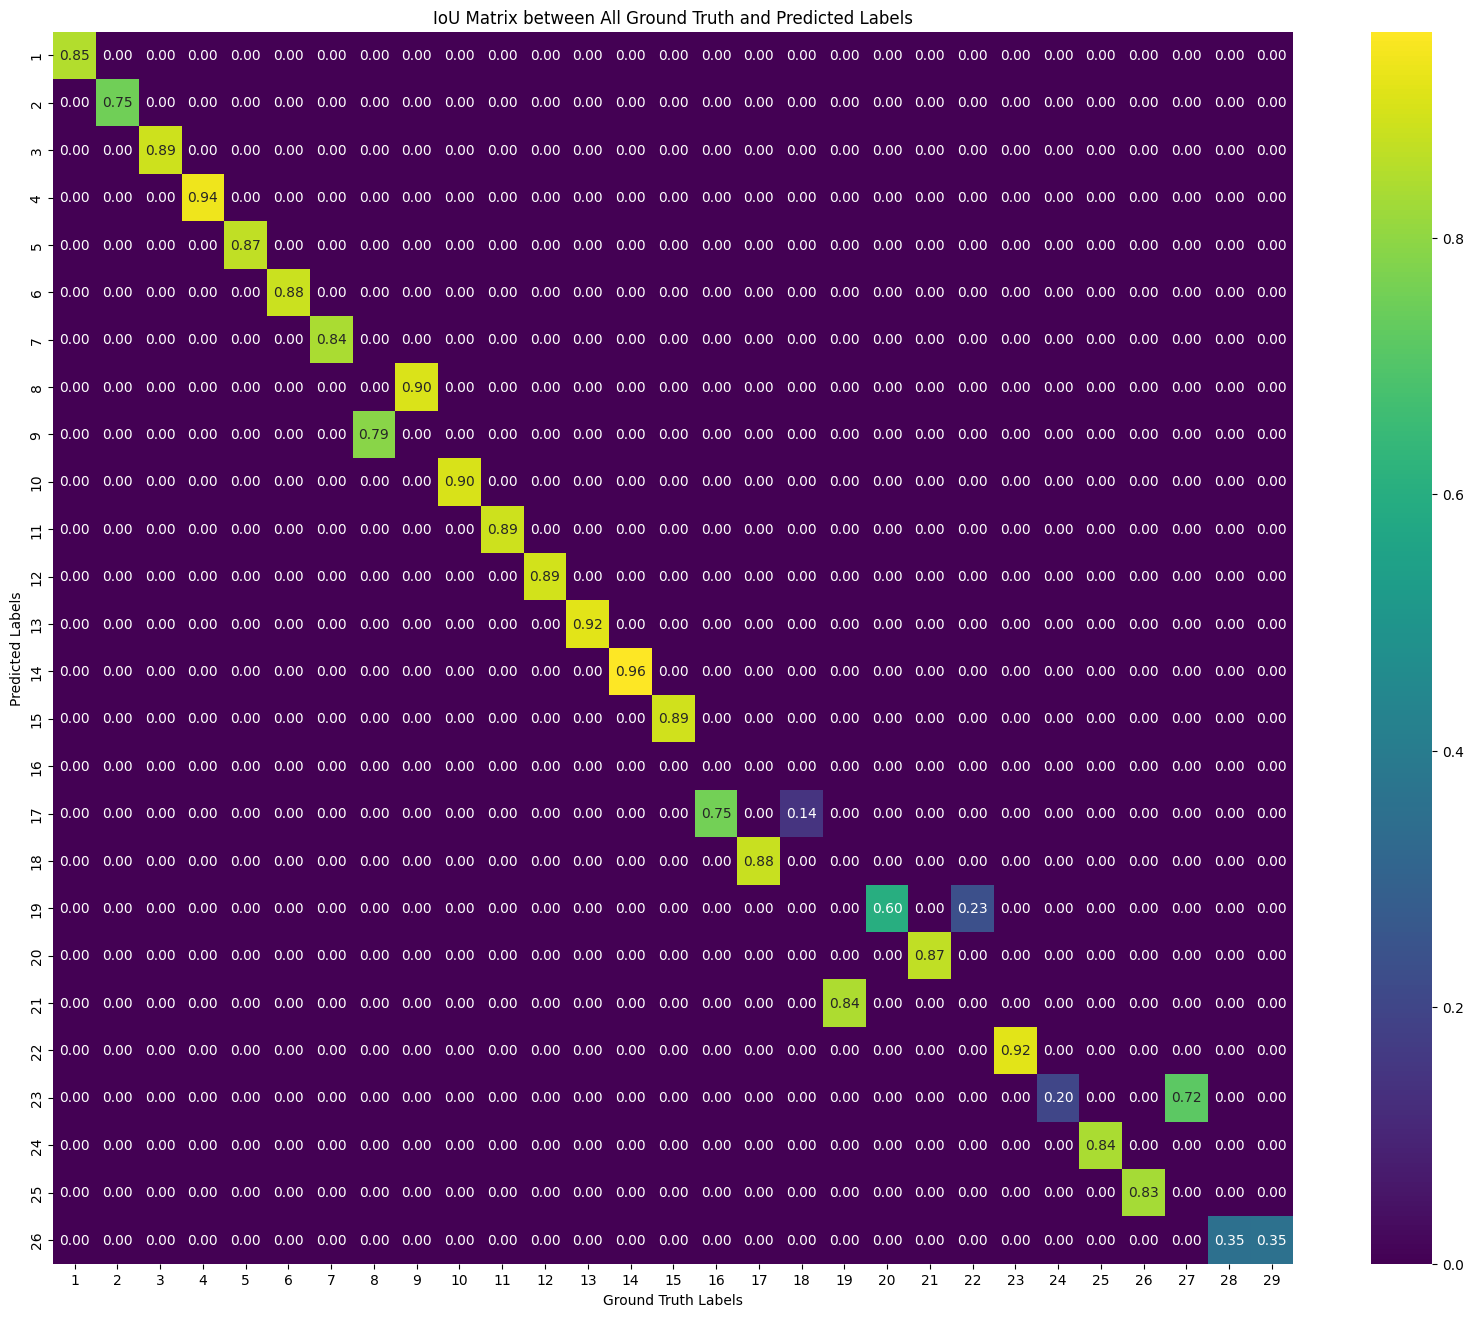

   IoU Threshold  True Positives  False Positives  False Negatives  \
0            0.5              24                5                2   
1            0.6              24                5                2   
2            0.7              23                6                3   
3            0.8              19               10                7   
4            0.9               6               23               20   

   Average Precision  
0           0.774194  
1           0.774194  
2           0.718750  
3           0.527778  
4           0.122449  


In [7]:
import torch
import torchmetrics
import numpy as np
import scipy.ndimage as ndi
import pandas as pd
import matplotlib.pyplot as plt

num_images = 4

for i in range(num_images):

    binary_mask = all_labels_tensor[i].cpu().numpy() == 1  # Change the class index if needed
    binary_prediction = all_predictions_tensor[i].cpu().numpy() == 1  # Change the class index if needed

    # Label the connected components if not already labeled (reusing previously labeled masks)
    labeled_mask, _ = ndi.label(binary_mask)  # binary_mask from previous steps
    labeled_prediction, _ = ndi.label(binary_prediction)  # binary_prediction from previous steps

    # Assuming labeled_mask and labeled_prediction are defined
    unique_labels_true = np.unique(labeled_mask)
    unique_labels_pred = np.unique(labeled_prediction)

    # Initialize the DataFrame to store IoU values
    # Adjust DataFrame initialization: switch 'unique_labels_true' and 'unique_labels_pred'
    iou_df = pd.DataFrame(index=unique_labels_pred, columns=unique_labels_true, dtype=float)

    # Instantiate a Jaccard Index metric object
    jaccard_index = torchmetrics.JaccardIndex(task = 'binary', num_classes=2)

    # Calculate IoU for each pair of labels
    for true_label in unique_labels_true:
        for pred_label in unique_labels_pred:
            blob_true = (labeled_mask == true_label).astype(int)
            blob_pred = (labeled_prediction == pred_label).astype(int)

            blob_true_tensor = torch.tensor(blob_true)
            blob_pred_tensor = torch.tensor(blob_pred)

            # Reset the metric for each new calculation
            jaccard_index.reset()
            # Update with predicted as target and true as predictions to align with DataFrame index and column setup
            jaccard_index.update(blob_pred_tensor, blob_true_tensor)
            iou_score = jaccard_index.compute()

            # Store the IoU score in the DataFrame
            # Store IoU scores with predicted labels as rows and true labels as columns
            iou_df.loc[pred_label, true_label] = iou_score.item()

    # Remove the row and column for the background label if present (usually label 0)
    iou_df = iou_df.drop(index=0, columns=0, errors='ignore')

    # Print the IoU DataFrame
    print(iou_df)

    # Optionally, visualize the IoU matrix as a heatmap
    import seaborn as sns
    plt.figure(figsize=(20, 16))
    sns.heatmap(iou_df, annot=True, cmap='viridis', fmt=".2f")
    plt.title('IoU Matrix between All Ground Truth and Predicted Labels')
    plt.xlabel('Ground Truth Labels')
    plt.ylabel('Predicted Labels')
    plt.show()

    # Calculate AP across various IoU thresholds
    results = []
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

    for threshold in thresholds:
        TP = (iou_df.max(axis=0) >= threshold).sum()  # True Positives are now calculated across columns
        FP = (iou_df.max(axis=0) < threshold).sum()  # False Positives are also calculated across columns
        FN = (iou_df.max(axis=1) < threshold).sum()  # False Negatives are calculated across rows

        # Calculate Average Precision
        if TP + FP + FN > 0:
            AP = TP / (TP + FP + FN)
        else:
            AP = 0

        results.append({
            'IoU Threshold': threshold,
            'True Positives': TP,
            'False Positives': FP,
            'False Negatives': FN,
            'Average Precision': AP
        })

    # Convert results to DataFrame for easier viewing
    results_df = pd.DataFrame(results)
    results_df
    print(results_df)


In [8]:

# Assuming 'all_labels' and 'all_predictions' are defined and loaded tensors
num_images = 96  # Set the number of images you want to process

# Full path to save the Excel file
excel_path = '/data/leuven/360/vsc36057/transunet/transresunet/AP analysis/transresunet-large.xlsx'

# Initialize a DataFrame to store all AP values
all_ap_values = pd.DataFrame()

with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    # DataFrame to collect all results
    all_results_df = pd.DataFrame()
    
    for i in range(num_images):
        binary_mask = all_labels_tensor[i].cpu().numpy() == 1  # Adjust the class index if necessary
        binary_prediction = all_predictions_tensor[i].cpu().numpy() == 1  # Adjust the class index if necessary

        # Label the connected components
        labeled_mask, _ = ndi.label(binary_mask)
        labeled_prediction, _ = ndi.label(binary_prediction)

        unique_labels_true = np.unique(labeled_mask)
        unique_labels_pred = np.unique(labeled_prediction)

        iou_df = pd.DataFrame(index=unique_labels_pred, columns=unique_labels_true, dtype=float)
        jaccard_index = torchmetrics.JaccardIndex(task = 'binary', num_classes=2)

        for true_label in unique_labels_true:
            for pred_label in unique_labels_pred:
                blob_true = (labeled_mask == true_label).astype(int)
                blob_pred = (labeled_prediction == pred_label).astype(int)

                blob_true_tensor = torch.tensor(blob_true)
                blob_pred_tensor = torch.tensor(blob_pred)

                jaccard_index.reset()
                jaccard_index.update(blob_pred_tensor, blob_true_tensor)
                iou_score = jaccard_index.compute()

                iou_df.loc[pred_label, true_label] = iou_score.item()

        iou_df = iou_df.drop(index=0, columns=0, errors='ignore')

        # Calculate AP across various IoU thresholds
        results = []
        ap_values = []
        thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

        for threshold in thresholds:
            TP = (iou_df.max(axis=0) >= threshold).sum()
            FP = (iou_df.max(axis=0) < threshold).sum()
            FN = (iou_df.max(axis=1) < threshold).sum()

            AP = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
            results.append({
                'image number': i + 1,  # Start image numbering at 1
                'IoU Threshold': threshold,
                'True Positives': TP,
                'False Positives': FP,
                'False Negatives': FN,
                'Average Precision': AP
            })
            ap_values.append(AP)

        temp_df = pd.DataFrame(results)
        all_results_df = pd.concat([all_results_df, temp_df], ignore_index=True)
        
        # Collect all AP values for the final summary table
        all_ap_values[f'Image {i+1}'] = ap_values

    # Write the concatenated results to the Excel file
    all_results_df.to_excel(writer, sheet_name='AP Results', index=False)
    
    # Write the AP summary table to the Excel file
    all_ap_values.to_excel(writer, sheet_name='AP Summary', index=False)
